# RSNA Mammo - Exploratory Data Analysis

In [1]:
%%capture
# Source: https://www.kaggle.com/code/remekkinas/fast-dicom-processing-1-6-2x-faster?scriptVersionId=113360473

!pip install /kaggle/input/rsnamodules/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl 

try:
    import pylibjpeg
except:
   !pip install /kaggle/input/rsna-2022-whl/{pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import scipy
import pathlib
import pydicom
import functools
import itertools
import input_pipeline as ip

In [3]:
sns.set_theme()

In [4]:
!ls /kaggle/input/rsna-breast-cancer-detection

sample_submission.csv  test.csv  test_images  train.csv  train_images


In [5]:
INPUT_DIR = pathlib.Path('/kaggle/input/rsna-breast-cancer-detection')

In [6]:
train_csv_path = INPUT_DIR / 'train.csv'
train_df = pd.read_csv(train_csv_path)
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

In [8]:
train_df.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,5.470600e+04,54669.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,1.079386e+09,58.543928,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,6.183269e+08,10.050884,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,5.458153e+08,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,1.082689e+09,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,1.613228e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


In [9]:
# Number of patients.
train_df.patient_id.nunique()

11913

In [10]:
# Statistics about the number of images per patient.
train_df.groupby('patient_id').image_id.count().describe(percentiles=[0.5, 0.95, 0.99])

count    11913.000000
mean         4.592126
std          1.133216
min          4.000000
50%          4.000000
95%          7.000000
99%          9.000000
max         14.000000
Name: image_id, dtype: float64

<AxesSubplot:>

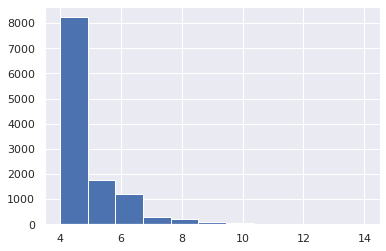

In [11]:
# Plot histogram of number of scans per patient.
train_df.groupby('patient_id').image_id.count().hist(bins=11)

In [12]:
train_df['view'].value_counts()

MLO    27903
CC     26765
AT        19
LM        10
ML         8
LMO        1
Name: view, dtype: int64

<AxesSubplot:xlabel='view', ylabel='count'>

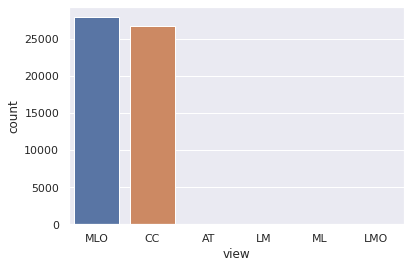

In [13]:
views = train_df['view'].value_counts().index
sns.countplot(x='view', data=train_df, order=views)

In [14]:
# The min/max number of L and R breast images per patient.
train_df.groupby(['patient_id', 'laterality']).image_id.agg([len]).agg([min, max])

,len
min,2
max,8


<AxesSubplot:xlabel='laterality', ylabel='count'>

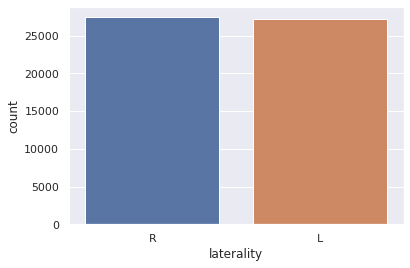

In [15]:
lateralities = train_df['laterality'].value_counts().index
sns.countplot(x='laterality', data=train_df, order=lateralities)

Accross the train dataset, patients each has 4 images or more. The majority of patients have the standard 4 images: 2 left (1 MLO and 1 CC) and 2 right (1 MLO and 1 CC).

For more information read the following article [radiopaedia | mammography views](https://radiopaedia.org/articles/mammography-views).

<AxesSubplot:xlabel='cancer', ylabel='count'>

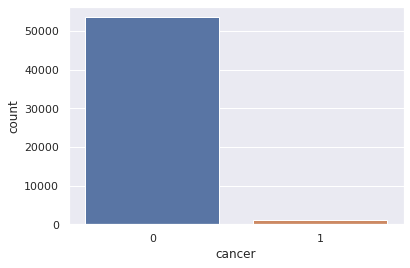

In [16]:
cancer_categories = train_df['cancer'].value_counts().index
sns.countplot(x='cancer', data=train_df, order=cancer_categories)

In [17]:
num_with_cancer = train_df[train_df.cancer == 1].size
num_without_cancer = train_df[train_df.cancer == 0].size

num_without_cancer / num_with_cancer

46.241796200345426

There is an imbalance between the number of cancerous images and healthy ones: ~46 more healthy images. This should be taken into account during training.

<AxesSubplot:xlabel='density', ylabel='count'>

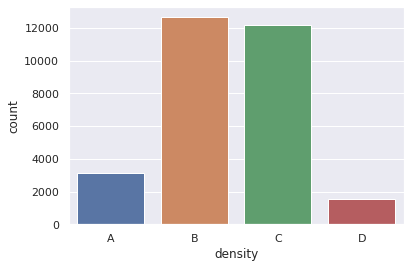

In [18]:
# density: A rating for how dense the breast tissue is, with A being the least dense
# and D being the most dense. Extremely dense tissue can make diagnosis more difficult.

density_categories = sorted(train_df['density'].value_counts().index)
sns.countplot(x='density', data=train_df, order=density_categories)

array([[<AxesSubplot:title={'center':'max'}>]], dtype=object)

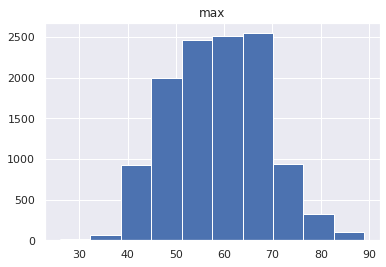

In [19]:
healthy_df = train_df[train_df.cancer == 0]
healthy_df.groupby('patient_id').age.agg([max]).hist()

In [20]:
healthy_df.groupby('patient_id').age.agg([max]).agg([np.mean])

,max
mean,58.638541


array([[<AxesSubplot:title={'center':'max'}>]], dtype=object)

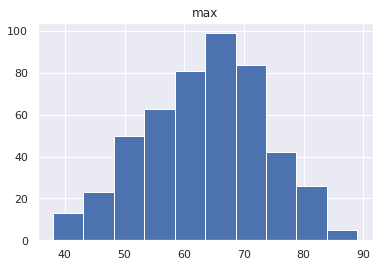

In [21]:
cancer_df = train_df[train_df.cancer == 1]
cancer_df.groupby('patient_id').age.agg([max]).hist()

In [22]:
cancer_df.groupby('patient_id').age.agg([max]).agg([np.mean])

,max
mean,63.493827


In [23]:
scipy.stats.spearmanr(
    train_df.groupby('patient_id').age.agg([max]).to_numpy(),
    train_df.groupby('patient_id').cancer.agg([max]).to_numpy(),
    nan_policy='omit',
)

SpearmanrResult(correlation=0.09904752331320425, pvalue=2.412371509964273e-27)

## Image Analysis

In [24]:
!ls /kaggle/input/rsna-breast-cancer-detection/train_images/10006

1459541791.dcm	1864590858.dcm	1874946579.dcm	462822612.dcm


In [25]:
# TODO: Annotate.
def scrape_dcm_headers(root: pathlib.Path):
  readfn = functools.partial(
      pydicom.dcmread, 
      stop_before_pixels=True)
  return (readfn(p) for p in root.rglob('*.dcm'))

In [26]:
# TODO: Run in parallel.
# WARNING: VERY SLOW
dcms = list(scrape_dcm_headers(INPUT_DIR))

<AxesSubplot:>

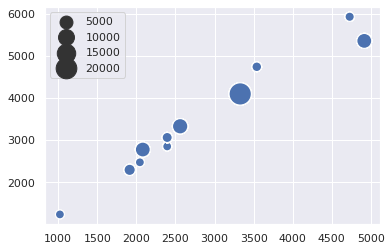

In [27]:
resolutions = ((d.Rows, d.Columns) for d in dcms)
heights, widths = zip(*resolutions)

freqs = collections.Counter(zip(heights, widths))
weights = [freqs[(h, w)] for h, w in zip(heights, widths)]

sns.scatterplot(
    x=widths, y=heights, 
    size=weights, # The corresponding weight of each point.
    sizes=(80, 500), # Min/Max pt size to use when plotting.
)

/kaggle/input/rsna-breast-cancer-detection/train_images/5/640805896.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/5/1351088028.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/5/940388076.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/5/1633417959.dcm


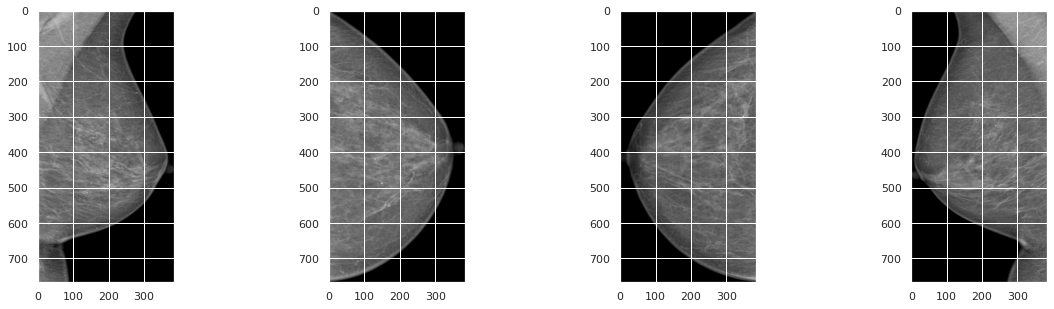

/kaggle/input/rsna-breast-cancer-detection/train_images/25/1442180348.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/25/1789648218.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/25/822390278.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/25/1723979573.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/25/1962456803.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/25/1997933901.dcm


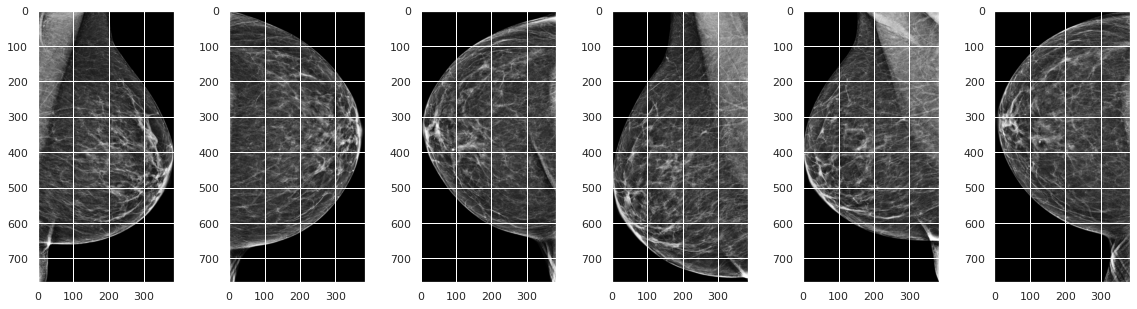

/kaggle/input/rsna-breast-cancer-detection/train_images/28/825270681.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/28/1113093954.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/28/145056531.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/28/2108025467.dcm


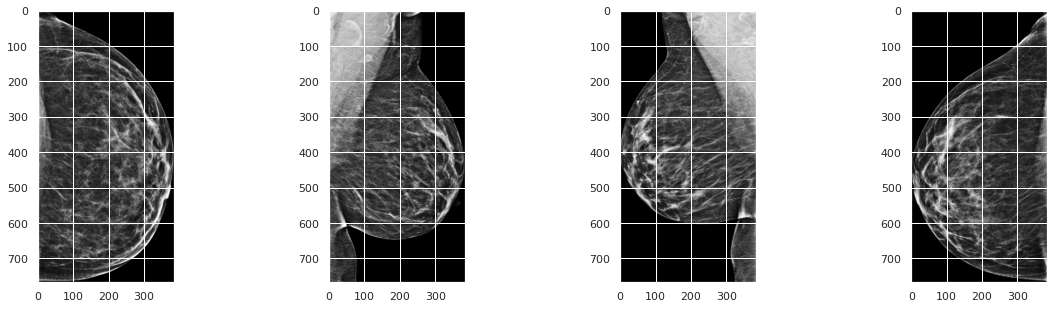

/kaggle/input/rsna-breast-cancer-detection/train_images/30/275846607.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/30/1153448462.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/30/244873631.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/30/924301348.dcm


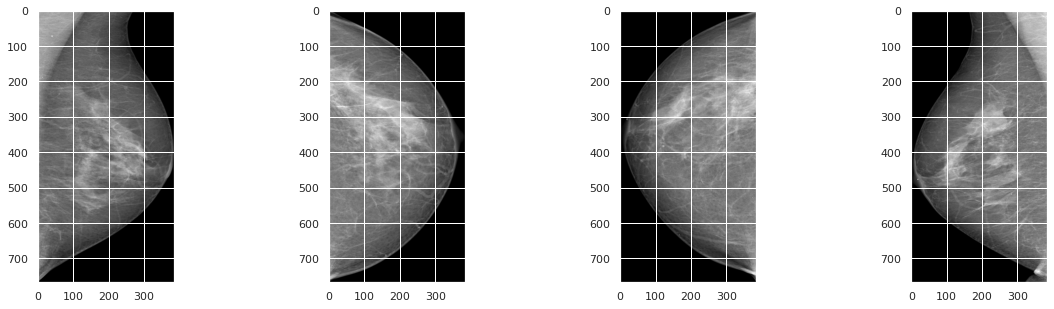

/kaggle/input/rsna-breast-cancer-detection/train_images/33/995020214.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/33/2057464302.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/33/567858385.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/33/1579089732.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/33/1863578666.dcm


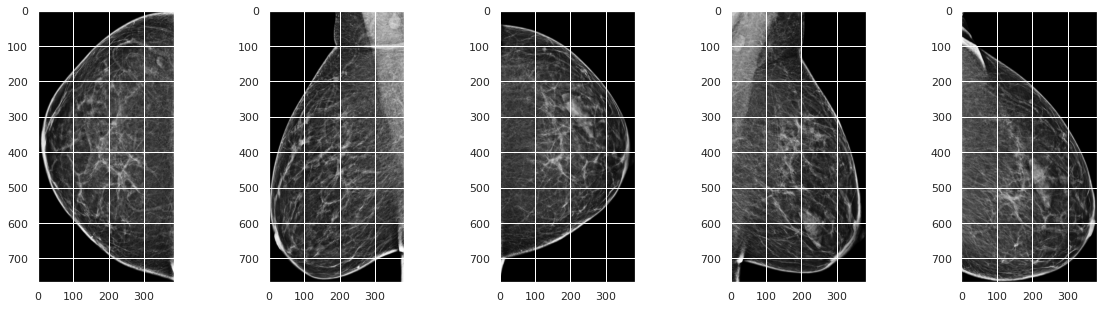

/kaggle/input/rsna-breast-cancer-detection/train_images/36/164115176.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/36/1877920136.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/36/2109485229.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/36/200779059.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/36/1161539227.dcm


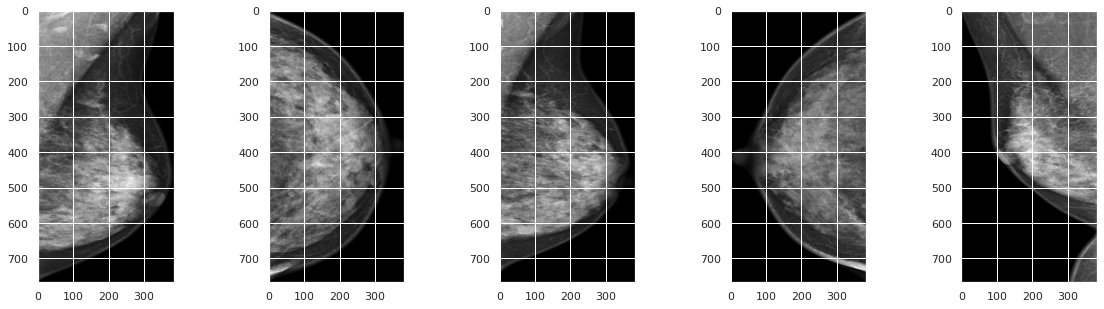

/kaggle/input/rsna-breast-cancer-detection/train_images/45/310190625.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/45/1476755745.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/45/1476454372.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/45/2102838312.dcm


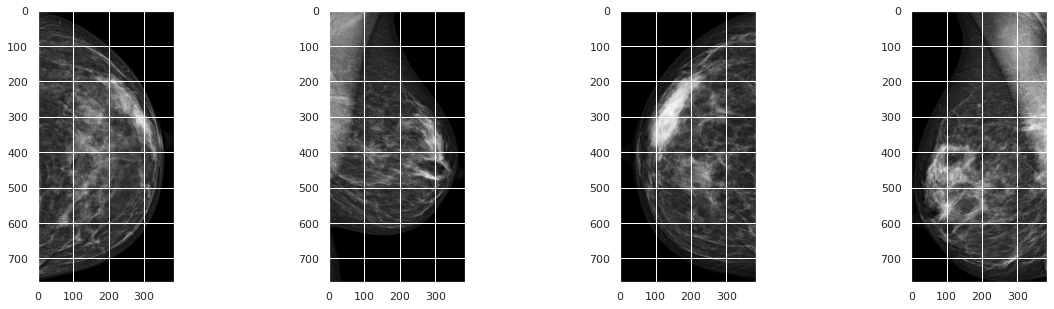

/kaggle/input/rsna-breast-cancer-detection/train_images/49/373605482.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/49/1504346730.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/49/323049527.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/49/872677361.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/49/1074487659.dcm


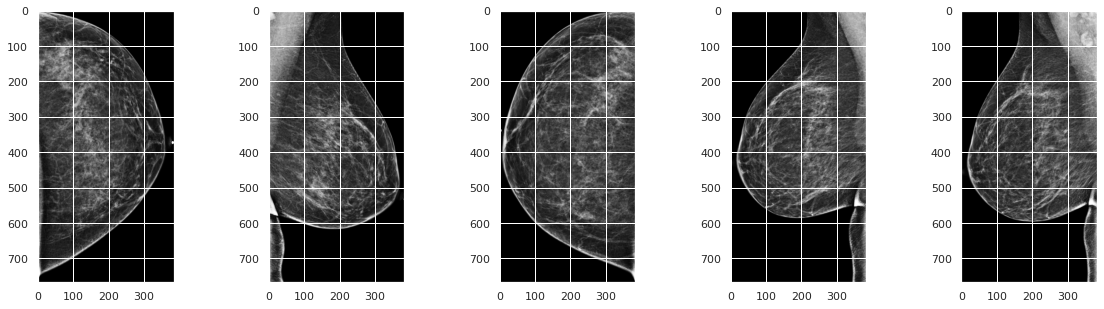

/kaggle/input/rsna-breast-cancer-detection/train_images/65/1477365269.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/65/1478763463.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/65/2028828273.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/65/2055627296.dcm


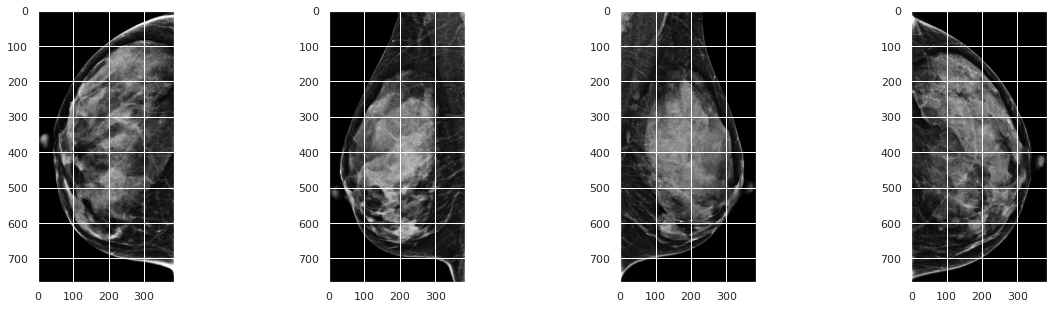

/kaggle/input/rsna-breast-cancer-detection/train_images/71/198449006.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/71/1405295276.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/71/1249745058.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/71/2004100590.dcm


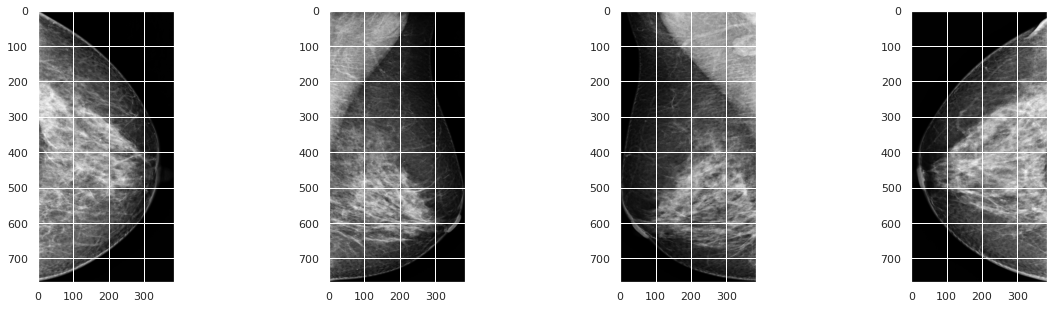

/kaggle/input/rsna-breast-cancer-detection/train_images/72/91376878.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/72/263272911.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/72/158596367.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/72/1062143065.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/72/1178581512.dcm


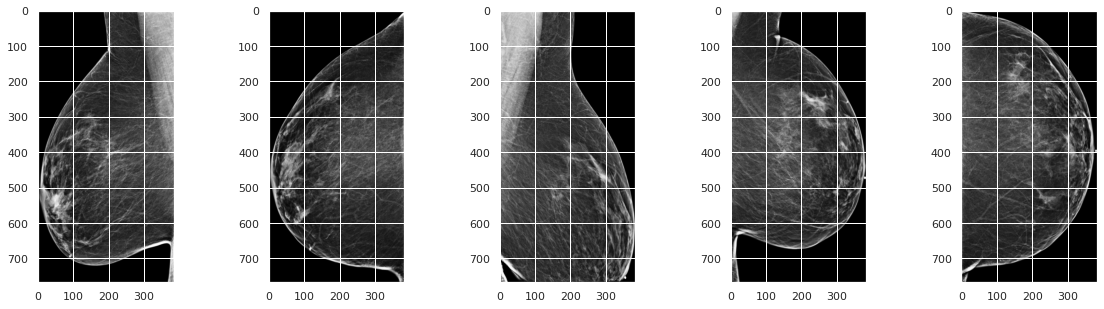

/kaggle/input/rsna-breast-cancer-detection/train_images/79/324319833.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/79/1043635482.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/79/1032716115.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/79/1968162207.dcm


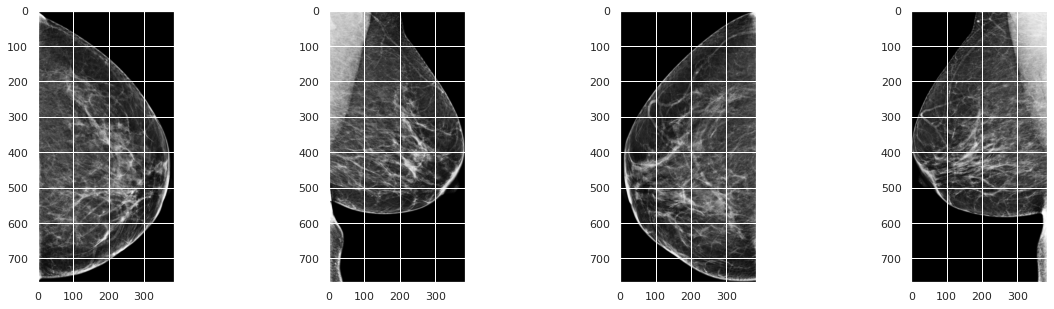

/kaggle/input/rsna-breast-cancer-detection/train_images/87/236738285.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/87/657445409.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/87/593005919.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/87/828025814.dcm


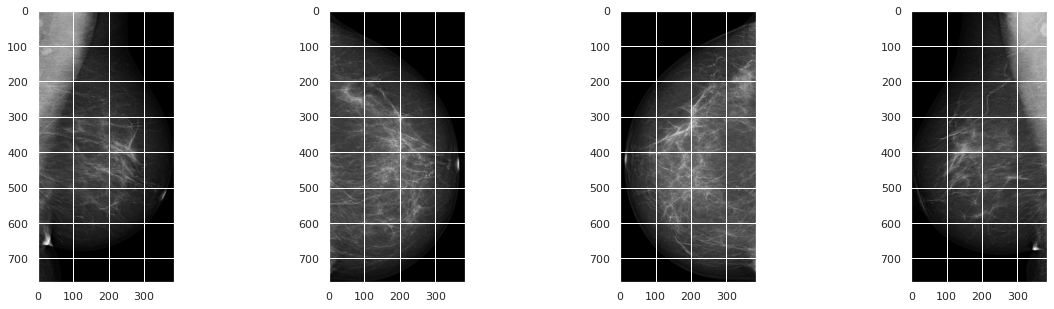

/kaggle/input/rsna-breast-cancer-detection/train_images/90/686742694.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/90/1756468328.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/90/332777290.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/90/2035421283.dcm


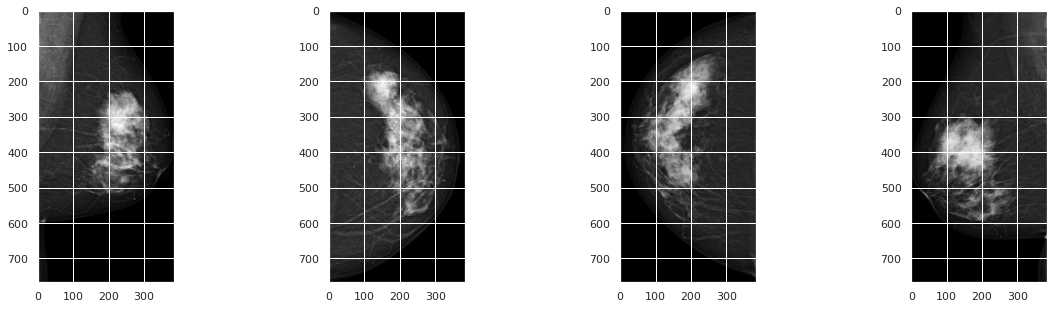

/kaggle/input/rsna-breast-cancer-detection/train_images/105/397491913.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/105/1232990271.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/105/928983724.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/105/1934323665.dcm


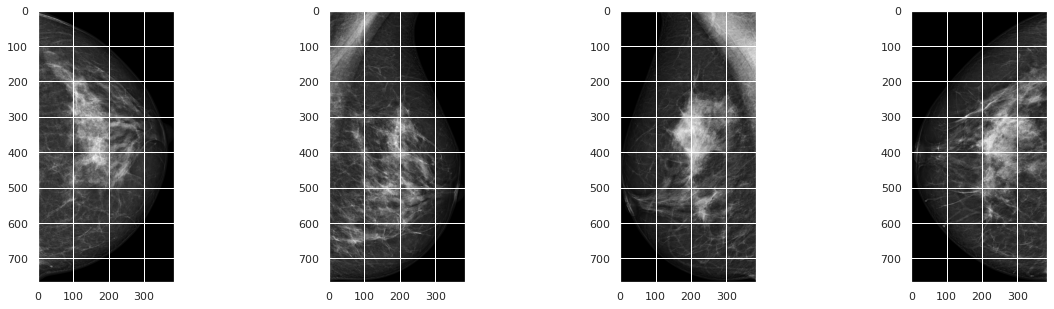

/kaggle/input/rsna-breast-cancer-detection/train_images/106/76321767.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/106/2018825992.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/106/1160585918.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/106/1495797827.dcm


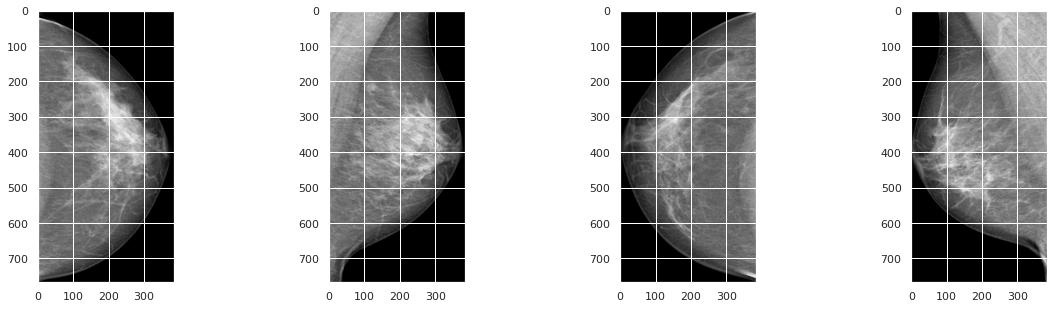

/kaggle/input/rsna-breast-cancer-detection/train_images/111/1832892866.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/111/2132807803.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/111/733212193.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/111/780010746.dcm


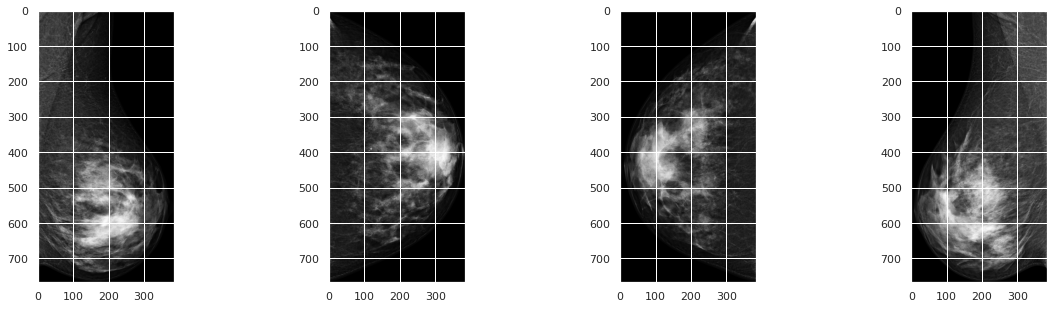

/kaggle/input/rsna-breast-cancer-detection/train_images/115/1726562879.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/115/2071926579.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/115/463070125.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/115/503361456.dcm


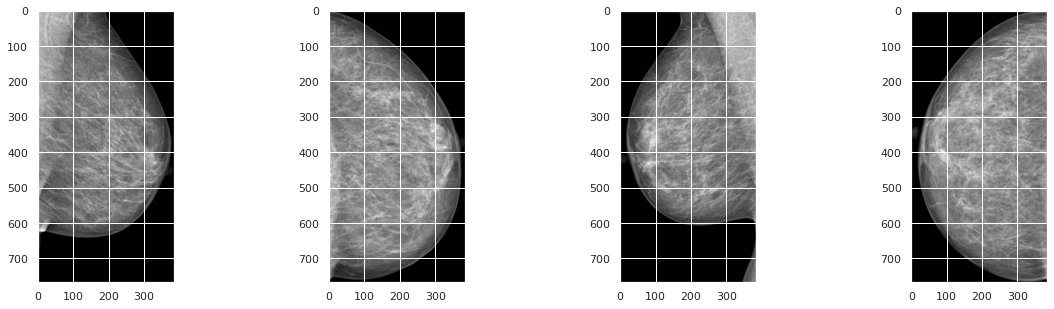

/kaggle/input/rsna-breast-cancer-detection/train_images/122/473043625.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/122/1302871879.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/122/273696199.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/122/921937972.dcm


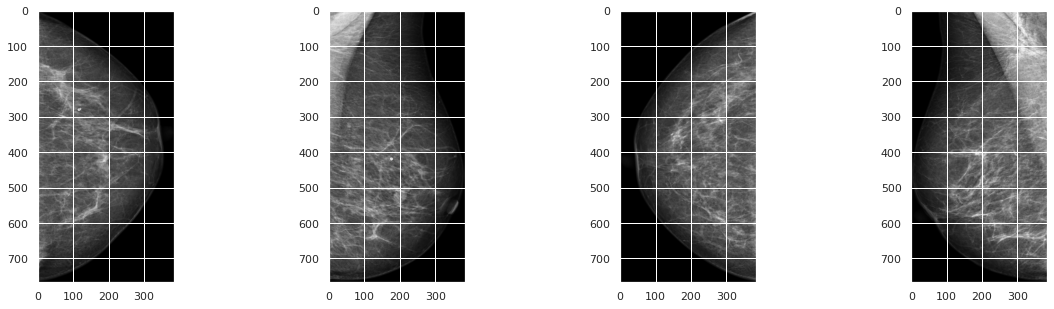

/kaggle/input/rsna-breast-cancer-detection/train_images/126/188647636.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/126/1935916379.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/126/840784409.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/126/1280524447.dcm


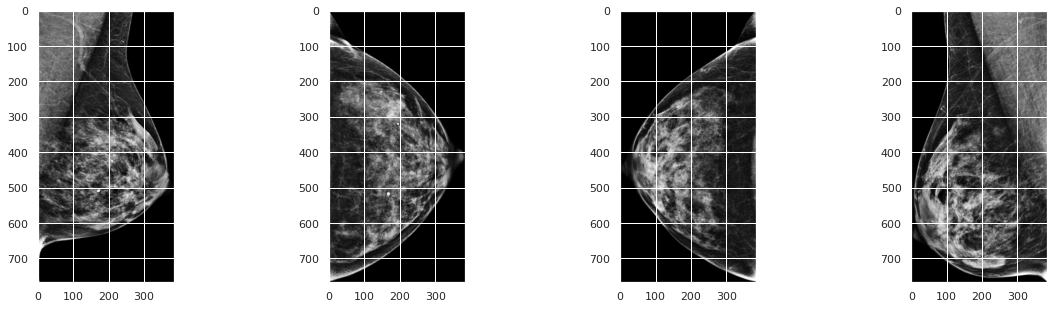

In [28]:
# TODO show 2 Left and 2 Right and add captions.

for _, df in itertools.islice(train_df.groupby('patient_id'), 20):
  fig = plt.figure(figsize=(20, 5))
  
  num_cols = len(df)
  for i, (_, r) in enumerate(df.iterrows()):
    p = INPUT_DIR / 'train_images' / f'{r.patient_id}' / f'{r.image_id}.dcm'
    print(p)
    plt.subplot(1, num_cols, i + 1)
    plt.imshow(ip.loadbreastimg(p), cmap='gray')
  plt.show()